# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Master/Dizertatie
!ls

/content/drive/MyDrive/Master/Dizertatie
 DATASETS			   hs-dl-methods.ipynb	 hs-transformers.ipynb		  TESTS
 distilbert-base-uncased_logs	   hs-eda.ipynb		 hs-transformers-multiple.ipynb
 distilbert-base-uncased_results   hs-full-code.ipynb	'NO EDIT'
 glove.6B.50d.txt		   hs-ml-methods.ipynb	 RESULTS


# Install Required Packages

In [3]:
!pip install transformers
!pip install optuna
!pip install accelerate -U
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 8.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_

# Import Libraries

In [4]:
import os
import re
import random
import string
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import softmax

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             precision_recall_fscore_support, roc_curve, roc_auc_score,
                             auc, confusion_matrix, classification_report)
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import (Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, Reshape)
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop, SGD

from transformers import (BertTokenizer, TFBertModel, AutoTokenizer,
                          AutoModelForSequenceClassification, Trainer, TrainingArguments,
                          logging)
logging.set_verbosity_error()

from torch.utils.data import DataLoader
from datasets import Dataset, load_metric

import optuna
import gensim.downloader as api

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [5]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
!unzip /root/nltk_data/corpora/wordnet.zip -d /root/nltk_data/corpora/

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Archive:  /root/nltk_data/corpora/wordnet.zip
   creating: /root/nltk_data/corpora/wordnet/
  inflating: /root/nltk_data/corpora/wordnet/lexnames  
  inflating: /root/nltk_data/corpora/wordnet/data.verb  
  inflating: /root/nltk_data/corpora/wordnet/index.adv  
  inflating: /root/nltk_data/corpora/wordnet/adv.exc  
  inflating: /root/nltk_data/corpora/wordnet/index.verb  
  inflating: /root/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /root/nltk_data/corpora/wordnet/data.adj  
  inflating: /root/nltk_data/corpora/wordnet/index.adj  
  inflating: /root/nltk_data/corpora/wordnet/LICENSE  
  inflating: /root/nltk_data/corpora/wordnet/citation.bib  
  inflating: /root/nltk_data/corpora/wordnet/noun.exc  
  inflating: /root/nltk_data/corpora/wordnet/verb.exc  
  inflating: /root/nltk_data/corpora/wordnet/README  
  inflating: /root/nltk_data/corpora/wordnet/index.sense  
  inflating: /root/nltk_data/corpora/wordnet/data.noun  
  inflating: /root/nltk_data/corpora/wordnet/data.adv  


# Set Parameters

In [6]:
#@title Dataset

dataset_name = 'Davidson' #@param ["Hateval2019", "Davidson"] {allow-input: true}

print(dataset_name)

Davidson


In [7]:
#@title Embedding Method

embedding_method_name = 'GloVe' #@param ["ELMo", "FastText", "Word2Vec", "GloVe", "BERT"] {allow-input: true}

print(embedding_method_name)

GloVe


In [8]:
#@title Algorithm Class

algorithm_class = 'deep-learning' #@param ["machine-learning", "deep-learning", "transformers"] {allow-input: true}

In [9]:
#@title Machine Learning Algorithm

machine_learning_algorithm = 'GNB' #@param ["GNB", "BNB", "LR", "SVM"] {allow-input: true}

In [10]:
#@title Deep Learning Model

deep_learning_model = 'M-Bi-GRU' #@param ["LSTM", "GRU", "Bi-LSTM", "Bi-GRU", "M-LSTM", "M-GRU", "M-Bi-LSTM", "M-Bi-GRU"] {allow-input: true}

In [11]:
#@title Optimization Mode

optimization_mode = False # @param {type:"boolean"}


In [12]:
#@title Transformer Model

transformer_model = "distilbert-base-uncased" # @param {type:"string"}

In [13]:
#@title Save Results

save_results = False # @param {type:"boolean"}


# Load Datasets

In [14]:
def load_hateval2019_dataset(file_path: str):
    column_names = ["id", "text", "HS", "TR", "AG"]
    df = pd.read_csv(file_path, names=column_names, header=0)
    return df

In [15]:
def load_davidson_dataset(file_path: str):
    column_names = ["count", "hate_speech", "offensive_language", "neither", "class", "tweet"]
    df = pd.read_csv(file_path, names=column_names, header=0)
    return df

In [16]:
start = time.time()
hateval2019_dataset = load_hateval2019_dataset("/content/drive/MyDrive/Master/Dizertatie/DATASETS/HATEVAL/hateval2019_en.csv")
end = time.time()
print(f"Execution time: {end-start:.2f} seconds")

Execution time: 2.13 seconds


In [17]:
start = time.time()
davidson_dataset = load_davidson_dataset("/content/drive/MyDrive/Master/Dizertatie/DATASETS/TWITTER/labeled_data2.csv")
end = time.time()
print(f"Execution time: {end-start:.2f} seconds")

Execution time: 1.86 seconds


In [18]:
if dataset_name == 'Hateval2019':
  data = hateval2019_dataset['text']
  labels = hateval2019_dataset['HS']
elif dataset_name == 'Davidson':
  data = davidson_dataset['tweet']
  labels = davidson_dataset['class'].apply(lambda x: 1 if x == 0 or x == 1 else 0)

# Prepocess Data

In [19]:
def preprocess_text(text):

    # Remove HTML tags and URLs
    text = re.sub('<[^<]+?>', '', text)
    text = re.sub(r'http\S+', '', text)

    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Convert to lowercase
    tokens = [token.lower() for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the preprocessed tokens back into a string
    preprocessed_text = " ".join(tokens)

    return preprocessed_text

In [20]:
data = data.apply(preprocess_text)

# Load Embeddings

In [21]:
def load_glove_model(file_path):
    glove_model = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_model[word] = vector
    return glove_model

In [22]:
def glove_vectors(text):
    embeddings = []

    # Get the vector size from the first word in the dictionary
    vector_size = len(next(iter(glove_model.values())))
    zero_vector = np.zeros(vector_size)

    for sentence in text:
        words = sentence.split()
        sentence_embeddings = [glove_model[word] for word in words if word in glove_model]

        if not sentence_embeddings:
            sentence_embeddings = [zero_vector]

        embeddings.append(np.mean(sentence_embeddings, axis=0))

    return np.array(embeddings)

In [23]:
def elmo_vectors(text, batch_size=8):
    num_batches = len(text) // batch_size + (1 if len(text) % batch_size > 0 else 0)
    embeddings = []

    for i in range(num_batches):
        start_index = i * batch_size
        end_index = min((i + 1) * batch_size, len(text))
        batch_text = text[start_index:end_index]
        batch_embeddings = elmo(tf.convert_to_tensor(batch_text.tolist()), training=False)
        embeddings.append(batch_embeddings.numpy())

    return np.concatenate(embeddings, axis=0)

In [24]:
def fasttext_word2vec_vectors(text, model):
    embeddings = []
    zero_vector = np.zeros(model.vector_size)

    for sentence in text:
        words = sentence.split()
        sentence_embeddings = [model[word] for word in words if word in model]

        if not sentence_embeddings:
            sentence_embeddings = [zero_vector]

        embeddings.append(np.mean(sentence_embeddings, axis=0))

    return np.array(embeddings)

In [25]:
def bert_vectors(text, batch_size=32):
    # Load the BERT tokenizer and model
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = TFBertModel.from_pretrained("bert-base-uncased")

    # Compute the number of batches
    num_batches = len(text) // batch_size + (1 if len(text) % batch_size > 0 else 0)
    embeddings = []

    for i in range(num_batches):
        start_index = i * batch_size
        end_index = min((i + 1) * batch_size, len(text))
        batch_text = text[start_index:end_index]

        # Tokenize the batch of text and generate input tensors for the model
        inputs = tokenizer(batch_text.tolist(), return_tensors="tf", padding=True, truncation=True, max_length=512)

        # Generate embeddings for the batch using the BERT model
        outputs = model(inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :]
        embeddings.append(batch_embeddings.numpy())

    return np.concatenate(embeddings, axis=0)

In [26]:
if algorithm_class == "transformers":
  pass
elif embedding_method_name == "ELMo":
  elmo = hub.KerasLayer("https://tfhub.dev/google/elmo/3", trainable=False)
  embeddings_func = elmo_vectors
elif embedding_method_name == "FastText":
  fasttext_model = api.load("fasttext-wiki-news-subwords-300")
  embeddings_func = lambda text: fasttext_word2vec_vectors(text, fasttext_model)
elif embedding_method_name == "Word2Vec":
  word2vec_model = api.load("word2vec-google-news-300")
  embeddings_func = lambda text: fasttext_word2vec_vectors(text, word2vec_model)
elif embedding_method_name == "GloVe":
  glove_model = load_glove_model('/content/drive/MyDrive/Master/Dizertatie/glove.6B.50d.txt')
  embeddings_func = glove_vectors
elif embedding_method_name == "BERT":
  bert = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3", trainable=False)
  embeddings_func = bert_vectors

In [27]:
embeddings = embeddings_func(data)
print(f"{embedding_method_name} embeddings shape:", embeddings.shape)

GloVe embeddings shape: (8326, 50)


# Split Data

In [28]:
if algorithm_class == "machine-learning":

  train_ratio = 80
  test_ratio = 20

  data_to_split = embeddings

  train_data, test_data, train_labels, test_labels = train_test_split(data_to_split, labels, test_size=test_ratio/100, random_state=42, stratify=labels)

  print(train_data.shape)
  print(test_data.shape)
  print(test_labels.shape)
  print(test_labels.shape)

else:
  train_ratio = 80
  val_ratio = 10
  test_ratio = 10

  if algorithm_class == "deep-learning":
    data_to_split = embeddings
  elif algorithm_class == "transformers":
    data_to_split = data

  # Splitting the data into train and test sets
  train_val_data, test_data, train_val_labels, test_labels = train_test_split(
    data_to_split, labels, test_size=(test_ratio / 100), random_state=1, stratify=labels)

  # Calculating the remaining ratio after the test split
  remaining_ratio = 100 - test_ratio

  # Splitting the train_val set into train and validation sets with stratification
  train_data, val_data, train_labels, val_labels = train_test_split(
    train_val_data, train_val_labels, test_size=(val_ratio / remaining_ratio), random_state=1, stratify=train_val_labels)

  print(train_data.shape)
  print(val_data.shape)
  print(test_data.shape)
  print(train_labels.shape)
  print(val_labels.shape)
  print(test_labels.shape)

(6660, 50)
(833, 50)
(833, 50)
(6660,)
(833,)
(833,)


# Tokenize Data

In [29]:
if algorithm_class == "transformers":
  train_dataset = pd.DataFrame({"text": train_data, "label": train_labels})
  val_dataset = pd.DataFrame({"text": val_data, "label": val_labels})
  test_dataset = pd.DataFrame({"text": test_data, "label": test_labels})

In [30]:
if algorithm_class == "transformers":
  train_dataset = Dataset.from_pandas(train_dataset)
  val_dataset = Dataset.from_pandas(val_dataset)
  test_dataset = Dataset.from_pandas(test_dataset)

In [31]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=256)

In [32]:
if algorithm_class == "transformers":
  tokenizer = AutoTokenizer.from_pretrained(transformer_model)

In [33]:
if algorithm_class == "transformers":
  encoded_train_dataset = train_dataset.map(tokenize, batched=True, batch_size=None)
  encoded_val_dataset = val_dataset.map(tokenize, batched=True, batch_size=None)
  encoded_test_dataset = test_dataset.map(tokenize, batched=True, batch_size=None)

# Create Empty Dataframe to Store Results

In [34]:
if algorithm_class == "machine-learning":
  results_df = pd.DataFrame(columns=["GNB", "BNB", "LR", "SVM"],
                            index=["Accuracy-Train", "Accuracy-Test",
                                  "Execution-Train", "Execution-Test",
                                  "Precision-Train", "Precision-Test",
                                  "Recall-Train", "Recall-Test",
                                  "MAR-Train", "MAR-Test",
                                  "FAR-Train", "FAR-Test",
                                  "F1-Train", "F1-Test",
                                  "ROC-AUC-Train", "ROC-AUC-Test"])

elif algorithm_class == "deep-learning":
  results_df = pd.DataFrame(columns=["LSTM", "GRU", "Bi-LSTM", "Bi-GRU", "M-LSTM", "M-GRU", "M-Bi-LSTM", "M-Bi-GRU"],
                            index=["Accuracy-Train", "Accuracy-Val", "Accuracy-Test",
                                    "Loss-Train", "Loss-Val", "Loss-Test",
                                    "Execution-Train", "Execution-Val", "Execution-Test",
                                    "Precision-Train", "Precision-Val", "Precision-Test",
                                    "Recall-Train", "Recall-Val", "Recall-Test",
                                    "MAR-Train", "MAR-Val", "MAR-Test",
                                    "FAR-Train", "FAR-Val", "FAR-Test",
                                    "F1-Train", "F1-Val", "F1-Test",
                                    "ROC-AUC-Train", "ROC-AUC-Val", "ROC-AUC-Test"])

elif algorithm_class == "transfomers":
  results_df = pd.DataFrame(columns=[f"{transformer_model}"],
                            index=["Accuracy-Train", "Accuracy-Val", "Accuracy-Test",
                                    "Execution-Train", "Execution-Val", "Execution-Test",
                                    "Precision-Train", "Precision-Val", "Precision-Test",
                                    "Recall-Train", "Recall-Val", "Recall-Test",
                                    "F1-Train", "F1-Val", "F1-Test",
                                    "ROC-AUC-Train", "ROC-AUC-Val", "ROC-AUC-Test"])

# Machine Learning

## Gaussian Naive Bayes

In [35]:
if machine_learning_algorithm == "GNB" and algorithm_class == "machine-learning":
  start = time.time()
  gnb = GaussianNB()
  gnb.fit(train_data, train_labels)
  end = time.time()
  print(f"{machine_learning_algorithm} (Train) Execution time: {end-start:.2f} seconds")
  results_df.at["Execution-Train", machine_learning_algorithm] = end - start

In [36]:
if machine_learning_algorithm == "GNB" and algorithm_class == "machine-learning":
  start = time.time()
  gnb_accuracy = gnb.score(test_data, test_labels)
  end = time.time()
  print(f"{machine_learning_algorithm} (Test) Execution time: {end-start:.2f} seconds")
  results_df.at["Execution-Test", machine_learning_algorithm] = end - start

## Bernoulli Naive Bayes

In [37]:
if machine_learning_algorithm == "BNB" and algorithm_class == "machine-learning":
  start = time.time()
  bnb = BernoulliNB()
  bnb.fit(train_data, train_labels)
  end = time.time()
  print(f"{machine_learning_algorithm} (Train) Execution time: {end-start:.2f} seconds")
  results_df.at["Execution-Train", machine_learning_algorithm] = end - start

In [38]:
if machine_learning_algorithm == "BNB" and algorithm_class == "machine-learning":
  start = time.time()
  bnb_accuracy = bnb.score(test_data, test_labels)
  end = time.time()
  print(f"{machine_learning_algorithm} (Test) Execution time: {end-start:.2f} seconds")
  results_df.at["Execution-Test", machine_learning_algorithm] = end - start

## Logistic Regression

In [39]:
if machine_learning_algorithm == "LR" and algorithm_class == "machine-learning":
  start = time.time()
  lr = LogisticRegression()
  lr.fit(train_data, train_labels)
  end = time.time()
  print(f"{machine_learning_algorithm} (Train) Execution time: {end-start:.2f} seconds")
  results_df.at["Execution-Train", machine_learning_algorithm] = end - start

In [40]:
if machine_learning_algorithm == "LR" and algorithm_class == "machine-learning":
  start = time.time()
  lr_accuracy = lr.score(test_data, test_labels)
  end = time.time()
  print(f"{machine_learning_algorithm} (Test) Execution time: {end-start:.2f} seconds")
  results_df.at["Execution-Test", algorithm_machine_learning_algorithmname] = end - start

## Support Vector Machine

In [41]:
if machine_learning_algorithm == "SVM" and algorithm_class == "machine-learning":
  start = time.time()
  svm = SVC(probability=True)
  svm.fit(train_data, train_labels)
  end = time.time()
  print(f"{machine_learning_algorithm} (Train) Execution time: {end-start:.2f} seconds")
  results_df.at["Execution-Train", machine_learning_algorithm] = end - start

In [42]:
if machine_learning_algorithm == "SVM" and algorithm_class == "machine-learning":
  start = time.time()
  svm_accuracy = svm.score(test_data, test_labels)
  end = time.time()
  print(f"{machine_learning_algorithm} (Test) Execution time: {end-start:.2f} seconds")
  results_df.at["Execution-Test", machine_learning_algorithm] = end - start

## Evaluation

### Predictions

#### Train

In [43]:
if machine_learning_algorithm == "GNB" and algorithm_class == "machine-learning":
    pred_train_labels = gnb.predict(train_data)

elif machine_learning_algorithm == "BNB" and algorithm_class == "machine-learning":
    pred_train_labels = bnb.predict(train_data)

elif machine_learning_algorithm == "LR" and algorithm_class == "machine-learning":
    pred_train_labels= lr.predict(train_data)

elif machine_learning_algorithm == "SVM" and algorithm_class == "machine-learning":
    pred_train_labels = svm.predict(train_data)

In [44]:
if machine_learning_algorithm == "GNB" and algorithm_class == "machine-learning":
    pred_prob_train_labels = gnb.predict_proba(train_data)[:, 1]

elif machine_learning_algorithm == "BNB" and algorithm_class == "machine-learning":
    pred_prob_train_labels = bnb.predict_proba(train_data)[:, 1]

elif machine_learning_algorithm == "LR" and algorithm_class == "machine-learning":
    pred_prob_train_labels = lr.predict_proba(train_data)[:, 1]

elif machine_learning_algorithm == "SVM" and algorithm_class == "machine-learning":
    pred_prob_train_labels = svm.predict_proba(train_data)[:, 1]

#### Test

In [45]:
if machine_learning_algorithm == "GNB" and algorithm_class == "machine-learning":
    pred_test_labels = gnb.predict(test_data)

elif machine_learning_algorithm == "BNB" and algorithm_class == "machine-learning":
    pred_test_labels = bnb.predict(test_data)

elif machine_learning_algorithm == "LR" and algorithm_class == "machine-learning":
    pred_test_labels= lr.predict(test_data)

elif machine_learning_algorithm == "SVM" and algorithm_class == "machine-learning":
    pred_test_labels = svm.predict(test_data)

In [46]:
if machine_learning_algorithm == "GNB" and algorithm_class == "machine-learning":
    pred_prob_test_labels = gnb.predict_proba(test_data)[:, 1]

elif machine_learning_algorithm == "BNB" and algorithm_class == "machine-learning":
    pred_prob_test_labels = bnb.predict_proba(test_data)[:, 1]

elif machine_learning_algorithm == "LR" and algorithm_class == "machine-learning":
    pred_prob_test_labels = lr.predict_proba(test_data)[:, 1]

elif machine_learning_algorithm == "SVM" and algorithm_class == "machine-learning":
    pred_prob_test_labels = svm.predict_proba(test_data)[:, 1]

### Accuracies

#### Train

In [47]:
if machine_learning_algorithm == "GNB" and algorithm_class == "machine-learning":
  print(f"Gaussian Naive Bayes Train Accuracy: {gnb.score(train_data, train_labels) * 100:.2f}")
  results_df.at["Accuracy-Train", machine_learning_algorithm] = gnb.score(train_data, train_labels)

elif machine_learning_algorithm == "BNB" and algorithm_class == "machine-learning":
  print(f"Bernoulli Naive Bayes Train Accuracy: {bnb.score(train_data, train_labels) * 100:.2f}")
  results_df.at["Accuracy-Train", machine_learning_algorithm] = bnb.score(train_data, train_labels)

elif machine_learning_algorithm == "LR" and algorithm_class == "machine-learning":
  print(f"Logistic Regression Train Accuracy: {lr.score(train_data, train_labels) * 100:.2f}")
  results_df.at["Accuracy-Train", machine_learning_algorithm] = lr.score(train_data, train_labels)

elif machine_learning_algorithm == "SVM" and algorithm_class == "machine-learning":
  print(f"SVM Train Accuracy: {svm.score(train_data, train_labels) * 100:.2f}")
  results_df.at["Accuracy-Train", machine_learning_algorithm] = svm.score(train_data, train_labels)

#### Test

In [48]:
if machine_learning_algorithm == "GNB" and algorithm_class == "machine-learning":
  print(f"Gaussian Naive Bayes Test Accuracy: {gnb_accuracy * 100:.2f}")
  results_df.at["Accuracy-Test", machine_learning_algorithm] = gnb_accuracy

elif machine_learning_algorithm == "BNB" and algorithm_class == "machine-learning":
  print(f"Bernoulli Naive Bayes Test Accuracy: {bnb_accuracy * 100:.2f}")
  results_df.at["Accuracy-Test", machine_learning_algorithm] = bnb_accuracy

elif machine_learning_algorithm == "LR" and algorithm_class == "machine-learning":
  print(f"Logistic Regression Test Accuracy: {lr_accuracy * 100:.2f}")
  results_df.at["Accuracy-Test", machine_learning_algorithm] = lr_accuracy

elif machine_learning_algorithm == "SVM" and algorithm_class == "machine-learning":
  print(f"SVM Test Accuracy: {svm_accuracy * 100:.2f}")
  results_df.at["Accuracy-Test", machine_learning_algorithm] = svm_accuracy

### Precision, Recall and F1 Score

#### Train

In [49]:
if algorithm_class == "machine-learning":
  precision_train = precision_score(train_labels, pred_train_labels)
  recall_train = recall_score(train_labels, pred_train_labels)
  f1_train = f1_score(train_labels, pred_train_labels)

  results_df.at["Precision-Train", machine_learning_algorithm] = precision_train
  results_df.at["Recall-Train", machine_learning_algorithm] = recall_train
  results_df.at["F1-Train", machine_learning_algorithm] = f1_train

  print(f"{machine_learning_algorithm} (Train Set) - Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1 Score: {f1_train:.4f}")

#### Test

In [50]:
if algorithm_class == "machine-learning":
  precision_test = precision_score(test_labels, pred_test_labels)
  recall_test = recall_score(test_labels, pred_test_labels)
  f1_test = f1_score(test_labels, pred_test_labels)

  results_df.at["Precision-Test", machine_learning_algorithm] = precision_test
  results_df.at["Recall-Test", machine_learning_algorithm] = recall_test
  results_df.at["F1-Test", machine_learning_algorithm] = f1_test

  print(f"{machine_learning_algorithm} (Test Set) - Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1 Score: {f1_test:.4f}")

### MAR and FAR

In [51]:
def compute_mar(TN, FP, FN, TP):
    miss_alarm_rate = FN / (TP + FN)
    return miss_alarm_rate

In [52]:
def compute_far(TN, FP, FN, TP):
    false_alarm_rate = FP / (FP + TN)
    return false_alarm_rate

#### Train

In [53]:
if algorithm_class == "machine-learning":
  tn, fp, fn, tp = confusion_matrix(train_labels, pred_train_labels).ravel()

  mar_train = compute_mar(tn, fp, fn, tp)
  far_train = compute_far(tn, fp, fn, tp)

  results_df.at["MAR-Train", machine_learning_algorithm] = mar_train
  results_df.at["FAR-Train", machine_learning_algorithm] = far_train

  print(f"{machine_learning_algorithm} (Train Set) - MAR: {mar_train:.4f}, FAR: {far_train:.4f}")

#### Test

In [54]:
if algorithm_class == "machine-learning":
  tn, fp, fn, tp = confusion_matrix(test_labels, pred_test_labels).ravel()

  mar_test = compute_mar(tn, fp, fn, tp)
  far_test = compute_far(tn, fp, fn, tp)

  results_df.at["MAR-Test", machine_learning_algorithm] = mar_test
  results_df.at["FAR-Test", machine_learning_algorithm] = far_test

  print(f"{machine_learning_algorithm} (Test Set) - MAR: {mar_test:.4f}, FAR: {far_test:.4f}")

### ROC and AUC

#### Train

In [55]:
if algorithm_class == "machine-learning":
  # Compute ROC curve and AUC
  fpr_train, tpr_train, thresholds_train = roc_curve(train_labels, pred_prob_train_labels)
  roc_auc_train = auc(fpr_train, tpr_train)
  results_df.at["ROC-AUC-Train", machine_learning_algorithm] = roc_auc_train

  # Plot ROC curve
  plt.figure(figsize=(6, 4))
  plt.plot(fpr_train, tpr_train, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc_train:.2f})')
  plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'{machine_learning_algorithm} - Receiver Operating Characteristic (Train)')
  plt.legend(loc="lower right")
  if save_results:
      plt.savefig(f"RESULTS/ML/PLOTS/{embedding_method_name}_{machine_learning_algorithm}_ROC_Train")
  plt.show()

  # Print AUC score
  print(f"{machine_learning_algorithm} AUC: {roc_auc_train:.4f}")

#### Test

In [56]:
if algorithm_class == "machine-learning":
  # Compute ROC curve and AUC
  fpr_test, tpr_test, thresholds_test = roc_curve(test_labels, pred_prob_test_labels)
  roc_auc_test = auc(fpr_test, tpr_test)
  results_df.at["ROC-AUC-Test", machine_learning_algorithm] = roc_auc_test

  # Plot ROC curve
  plt.figure(figsize=(6, 4))
  plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc_test:.2f})')
  plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'{machine_learning_algorithm} - Receiver Operating Characteristic (Test)')
  plt.legend(loc="lower right")
  if save_results:
      plt.savefig(f"RESULTS/ML/PLOTS/{embedding_method_name}_{machine_learning_algorithm}_ROC_Test")
  plt.show()

### Confusion Matrix

#### Train

In [57]:
if algorithm_class == "machine-learning":
  # Create a confusion matrix
  cm = confusion_matrix(train_labels, pred_train_labels)

  # Use matplotlib to create a heatmap
  plt.figure(figsize=(4, 4))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)

  # Set up the labels
  tick_marks = np.arange(2)  # there are 2 classes: 0 and 1
  plt.xticks(tick_marks, [0, 1])
  plt.yticks(tick_marks, [0, 1], rotation=90)

  # Add the values in the cells
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], 'd'),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.title(f'{machine_learning_algorithm} - Confusion Matrix (Train)')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if save_results:
      plt.savefig(f"RESULTS/ML/PLOTS/{embedding_method_name}_{machine_learning_algorithm}_CM_Train", bbox_inches='tight')
  plt.show()

#### Test

In [58]:
if algorithm_class == "machine-learning":
  # Create a confusion matrix
  cm = confusion_matrix(test_labels, pred_test_labels)

  # Use matplotlib to create a heatmap
  plt.figure(figsize=(4, 4))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)

  # Set up the labels
  tick_marks = np.arange(2)  # there are 2 classes: 0 and 1
  plt.xticks(tick_marks, [0, 1])
  plt.yticks(tick_marks, [0, 1], rotation=90)

  # Add the values in the cells
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], 'd'),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.title(f'{machine_learning_algorithm} - Confusion Matrix (Test)')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if save_results:
      plt.savefig(f"RESULTS/ML/PLOTS/{embedding_method_name}_{machine_learning_algorithm}_CM_Test", bbox_inches='tight')
  plt.show()

In [59]:
if save_results == True and algorithm_class == "machine-learning":
    results_df.to_csv(f"RESULTS/ML/METRICS/{embedding_method_name}_results.csv")

In [60]:
results_df

,LSTM,GRU,Bi-LSTM,Bi-GRU,M-LSTM,M-GRU,M-Bi-LSTM,M-Bi-GRU
Accuracy-Train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Accuracy-Val,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Accuracy-Test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Loss-Train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Loss-Val,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Loss-Test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Execution-Train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Execution-Val,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Execution-Test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Precision-Train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Deep Learning

## LSTM Model

### Optimize LSTM Model

In [61]:
def objective(trial):
    # Define the model
    model = Sequential()
    model.add(Reshape((1, train_data.shape[1]), input_shape=(train_data.shape[1],)))
    n_units = trial.suggest_int('n_units', 4, 200)
    model.add(LSTM(n_units))
    model.add(Dense(1, activation='sigmoid'))

    # Hyperparameters
    optimizer_options = ['RMSprop', 'Adam', 'SGD']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

    if optimizer_selected == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_selected == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    n_epochs = trial.suggest_int('n_epochs', 2, 50)
    history = model.fit(train_data, train_labels, epochs=n_epochs, validation_data=(val_data, val_labels), verbose=0)

    # Evaluate
    score = model.evaluate(val_data, val_labels, verbose=0)
    return score[0]  # Return validation loss

if algorithm_class == "deep-learning" and deep_learning_model == "LSTM" and optimization_mode == True:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)

    # Print the result
    best_params = study.best_params
    print(f'Best params: {best_params}')
    print(f'Best score: {study.best_value}')

### Train LSTM Model

In [62]:
if algorithm_class == "deep-learning" and deep_learning_model == "LSTM" and optimization_mode == False and dataset_name == 'Hateval2019':
  best_params = {'n_units': 56, 'optimizer': 'RMSprop', 'learning_rate': 0.0018396184813426356, 'n_epochs': 18}
elif algorithm_class == "deep-learning" and deep_learning_model == "LSTM" and optimization_mode == False and dataset_name == 'Davidson':
  best_params = {'n_units': 125, 'optimizer': 'RMSprop', 'learning_rate': 0.00536792628255773, 'n_epochs': 45}

In [63]:
if algorithm_class == "deep-learning" and deep_learning_model == 'LSTM':
    # Define the model
    model = Sequential()
    model.add(Reshape((1, train_data.shape[1]), input_shape=(train_data.shape[1],)))
    model.add(LSTM(best_params['n_units']))
    model.add(Dense(1, activation='sigmoid'))

    if best_params['optimizer'] == 'RMSprop':
        optimizer = RMSprop(learning_rate=best_params['learning_rate'])
    elif best_params['optimizer'] == 'Adam':
        optimizer = Adam(learning_rate=best_params['learning_rate'])
    else:
        optimizer = SGD(learning_rate=best_params['learning_rate'])

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    start = time.time()
    model.fit(train_data, train_labels, epochs=best_params['n_epochs'], validation_data=(val_data, val_labels))
    end = time.time()
    results_df.at["Execution-Train", deep_learning_model] = end - start

    # Plot model
    if save_results == True:
      tf.keras.utils.plot_model(model, to_file=f'RESULTS/DAVIDSON/RNN/PLOTS/{deep_learning_model}_model.png', show_shapes=False)

## GRU Model

### Optimize GRU Model

In [64]:
def objective(trial):
    # Define the model
    model = Sequential()
    model.add(Reshape((1, train_data.shape[1]), input_shape=(train_data.shape[1],)))
    n_units = trial.suggest_int('n_units', 4, 200)
    model.add(GRU(n_units))
    model.add(Dense(1, activation='sigmoid'))

    # Hyperparameters
    optimizer_options = ['RMSprop', 'Adam', 'SGD']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

    if optimizer_selected == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_selected == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    n_epochs = trial.suggest_int('n_epochs', 2, 50)
    history = model.fit(train_data, train_labels, epochs=n_epochs, validation_data=(val_data, val_labels), verbose=0)

    # Evaluate
    score = model.evaluate(val_data, val_labels, verbose=0)
    return score[0]  # Return validation loss

if algorithm_class == "deep-learning" and deep_learning_model == "GRU" and optimization_mode == True:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)

    # Print the result
    best_params = study.best_params
    print(f'Best params: {best_params}')
    print(f'Best score: {study.best_value}')

### Train GRU Model

In [65]:
if algorithm_class == "deep-learning" and deep_learning_model == "GRU" and optimization_mode == False and dataset_name == 'Hateval2019':
  best_params = {'n_units': 16, 'optimizer': 'Adam', 'learning_rate': 0.00016682881930972022, 'n_epochs': 46}
elif algorithm_class == "deep-learning" and deep_learning_model == "GRU" and optimization_mode == False and dataset_name == 'Davidson':
  best_params = {'n_units': 103, 'optimizer': 'Adam', 'learning_rate': 0.00800356311681664, 'n_epochs': 5}

In [66]:
if algorithm_class == "deep-learning" and deep_learning_model == 'GRU':
    # Define the model
    model = Sequential()
    model.add(Reshape((1, train_data.shape[1]), input_shape=(train_data.shape[1],)))
    model.add(GRU(best_params['n_units']))
    model.add(Dense(1, activation='sigmoid'))

    if best_params['optimizer'] == 'RMSprop':
        optimizer = RMSprop(learning_rate=best_params['learning_rate'])
    elif best_params['optimizer'] == 'Adam':
        optimizer = Adam(learning_rate=best_params['learning_rate'])
    else:
        optimizer = SGD(learning_rate=best_params['learning_rate'])

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    start = time.time()
    model.fit(train_data, train_labels, epochs=best_params['n_epochs'], validation_data=(val_data, val_labels))
    end = time.time()
    results_df.at["Execution-Train", deep_learning_model] = end - start

    # Plot model
    if save_results == True:
      tf.keras.utils.plot_model(model, to_file=f'RESULTS/DAVIDSON/RNN/PLOTS/{deep_learning_model}_model.png', show_shapes=False)

## Bidirectional LSTM Model

### Optimize Bidirectional LSTM Model

In [67]:
def objective(trial):
    # Define the model
    model = Sequential()
    model.add(Reshape((1, train_data.shape[1]), input_shape=(train_data.shape[1],)))
    n_units = trial.suggest_int('n_units', 4, 200)
    model.add(Bidirectional(LSTM(n_units)))
    model.add(Dense(1, activation='sigmoid'))

    # Hyperparameters
    optimizer_options = ['RMSprop', 'Adam', 'SGD']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

    if optimizer_selected == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_selected == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    n_epochs = trial.suggest_int('n_epochs', 2, 50)
    history = model.fit(train_data, train_labels, epochs=n_epochs, validation_data=(val_data, val_labels), verbose=0)

    # Evaluate
    score = model.evaluate(val_data, val_labels, verbose=0)
    return score[0]  # Return validation loss

if algorithm_class == "deep-learning" and deep_learning_model == "Bi-LSTM" and optimization_mode == True:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)

    # Print the result
    best_params = study.best_params
    print(f'Best params: {best_params}')
    print(f'Best score: {study.best_value}')

### Train Bi-LSTM Model

In [68]:
if algorithm_class == "deep-learning" and deep_learning_model == "Bi-LSTM" and optimization_mode == False and dataset_name == 'Hateval2019':
  best_params = {'n_units': 140, 'optimizer': 'Adam', 'learning_rate': 4.871738191900015e-05, 'n_epochs': 38}
elif algorithm_class == "deep-learning" and deep_learning_model == "Bi-LSTM" and optimization_mode == False and dataset_name == 'Davidson':
  best_params = {'n_units': 192, 'optimizer': 'Adam', 'learning_rate': 0.0015374249148203659, 'n_epochs': 16}

In [69]:
if algorithm_class == "deep-learning" and deep_learning_model == 'Bi-LSTM':
    # Define the model
    model = Sequential()
    model.add(Reshape((1, train_data.shape[1]), input_shape=(train_data.shape[1],)))
    model.add(Bidirectional(LSTM(best_params['n_units'])))
    model.add(Dense(1, activation='sigmoid'))

    if best_params['optimizer'] == 'RMSprop':
        optimizer = RMSprop(learning_rate=best_params['learning_rate'])
    elif best_params['optimizer'] == 'Adam':
        optimizer = Adam(learning_rate=best_params['learning_rate'])
    else:
        optimizer = SGD(learning_rate=best_params['learning_rate'])

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    start = time.time()
    model.fit(train_data, train_labels, epochs=best_params['n_epochs'], validation_data=(val_data, val_labels))
    end = time.time()
    results_df.at["Execution-Train", deep_learning_model] = end - start

    # Plot model
    if save_results == True:
      tf.keras.utils.plot_model(model, to_file=f'RESULTS/DAVIDSON/RNN/PLOTS/{deep_learning_model}_model.png', show_shapes=False)

## Bidirectional GRU Model

### Optimize Bi-GRU Model

In [70]:
def objective(trial):
    # Define the model
    model = Sequential()
    model.add(Reshape((1, train_data.shape[1]), input_shape=(train_data.shape[1],)))
    n_units = trial.suggest_int('n_units', 4, 200)
    model.add(Bidirectional(GRU(n_units)))
    model.add(Dense(1, activation='sigmoid'))

    # Hyperparameters
    optimizer_options = ['RMSprop', 'Adam', 'SGD']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

    if optimizer_selected == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_selected == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    n_epochs = trial.suggest_int('n_epochs', 2, 50)
    history = model.fit(train_data, train_labels, epochs=n_epochs, validation_data=(val_data, val_labels), verbose=0)

    # Evaluate
    score = model.evaluate(val_data, val_labels, verbose=0)
    return score[0]  # Return validation loss

if algorithm_class == "deep-learning" and deep_learning_model == "Bi-GRU" and optimization_mode == True:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)

    # Print the result
    best_params = study.best_params
    print(f'Best params: {best_params}')
    print(f'Best score: {study.best_value}')

### Train Bi-GRU Model

In [71]:
if algorithm_class == "deep-learning" and deep_learning_model == "Bi-GRU" and optimization_mode == False and dataset_name == 'Hateval2019':
  best_params = {'n_units': 132, 'optimizer': 'Adam', 'learning_rate': 8.471060637037659e-05, 'n_epochs': 38}
elif algorithm_class == "deep-learning" and deep_learning_model == "Bi-GRU" and optimization_mode == False and dataset_name == 'Davidson':
  best_params = {'n_units': 4, 'optimizer': 'Adam', 'learning_rate': 0.006178562644869577, 'n_epochs': 27}

In [72]:
if algorithm_class == "deep-learning" and deep_learning_model == 'Bi-GRU':
    # Define the model
    model = Sequential()
    model.add(Reshape((1, train_data.shape[1]), input_shape=(train_data.shape[1],)))
    model.add(Bidirectional(GRU(best_params['n_units'])))
    model.add(Dense(1, activation='sigmoid'))

    if best_params['optimizer'] == 'RMSprop':
        optimizer = RMSprop(learning_rate=best_params['learning_rate'])
    elif best_params['optimizer'] == 'Adam':
        optimizer = Adam(learning_rate=best_params['learning_rate'])
    else:
        optimizer = SGD(learning_rate=best_params['learning_rate'])

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    start = time.time()
    model.fit(train_data, train_labels, epochs=best_params['n_epochs'], validation_data=(val_data, val_labels))
    end = time.time()
    results_df.at["Execution-Train", deep_learning_model] = end - start

    # Plot model
    if save_results == True:
      tf.keras.utils.plot_model(model, to_file=f'RESULTS/DAVIDSON/RNN/PLOTS/{deep_learning_model}_model.png', show_shapes=False)

## Multi-layer LSTM Model

### Optimize M-LSTM Model

In [73]:
def objective(trial):
    # Define the model
    model = Sequential()
    model.add(Reshape((1, train_data.shape[1]), input_shape=(train_data.shape[1],)))
    n_units_1 = trial.suggest_int('n_units_1', 4, 200)
    model.add(LSTM(n_units_1, return_sequences=True))
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.7)
    model.add(Dropout(dropout_rate))
    n_units_2 = trial.suggest_int('n_units_2', 4, 200)
    model.add(LSTM(n_units_2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Hyperparameters
    optimizer_options = ['RMSprop', 'Adam', 'SGD']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

    if optimizer_selected == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_selected == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    n_epochs = trial.suggest_int('n_epochs', 2, 50)
    history = model.fit(train_data, train_labels, epochs=n_epochs, validation_data=(val_data, val_labels), verbose=0)

    # Evaluate
    score = model.evaluate(val_data, val_labels, verbose=0)
    return score[0]  # Return validation loss

if algorithm_class == "deep-learning" and deep_learning_model == "M-LSTM" and optimization_mode == True:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=75)

    # Print the result
    best_params = study.best_params
    print(f'Best params: {best_params}')
    print(f'Best score: {study.best_value}')

### Train M-LSTM Model

In [74]:
if algorithm_class == "deep-learning" and deep_learning_model == "M-LSTM" and optimization_mode == False and dataset_name == 'Hateval2019':
  best_params = {'n_units_1': 115, 'dropout_rate': 0.5548187910815977, 'n_units_2': 195, 'optimizer': 'Adam', 'learning_rate': 6.622865093659962e-05, 'n_epochs': 41}
elif algorithm_class == "deep-learning" and deep_learning_model == "M-LSTM" and optimization_mode == False and dataset_name == 'Davidson':
  best_params = {'n_units_1': 107, 'dropout_rate': 0.6052276425998127, 'n_units_2': 78, 'optimizer': 'RMSprop', 'learning_rate': 0.0017310464944428508, 'n_epochs': 18}

In [75]:
if algorithm_class == "deep-learning" and deep_learning_model == 'M-LSTM':
    # Define the model
    model = Sequential()
    model.add(Reshape((1, train_data.shape[1]), input_shape=(train_data.shape[1],)))
    model.add(LSTM(best_params['n_units_1'], return_sequences=True))
    model.add(Dropout(best_params['dropout_rate']))
    model.add(LSTM(best_params['n_units_2']))
    model.add(Dropout(best_params['dropout_rate']))
    model.add(Dense(1, activation='sigmoid'))

    if best_params['optimizer'] == 'RMSprop':
        optimizer = RMSprop(learning_rate=best_params['learning_rate'])
    elif best_params['optimizer'] == 'Adam':
        optimizer = Adam(learning_rate=best_params['learning_rate'])
    else:
        optimizer = SGD(learning_rate=best_params['learning_rate'])

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    start = time.time()
    model.fit(train_data, train_labels, epochs=best_params['n_epochs'], validation_data=(val_data, val_labels))
    end = time.time()
    results_df.at["Execution-Train", deep_learning_model] = end - start

    # Plot model
    if save_results == True:
      tf.keras.utils.plot_model(model, to_file=f'RESULTS/DAVIDSON/RNN/PLOTS/{deep_learning_model}_model.png', show_shapes=False)

## Multi-layer GRU Model

### Optimize M-GRU

In [76]:
def objective(trial):
    # Define the model
    model = Sequential()
    model.add(Reshape((1, train_data.shape[1]), input_shape=(train_data.shape[1],)))
    n_units_1 = trial.suggest_int('n_units_1', 4, 200)
    model.add(GRU(n_units_1, return_sequences=True))
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.7)
    model.add(Dropout(dropout_rate))
    n_units_2 = trial.suggest_int('n_units_2', 4, 200)
    model.add(GRU(n_units_2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Hyperparameters
    optimizer_options = ['RMSprop', 'Adam', 'SGD']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

    if optimizer_selected == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_selected == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    n_epochs = trial.suggest_int('n_epochs', 2, 50)
    history = model.fit(train_data, train_labels, epochs=n_epochs, validation_data=(val_data, val_labels), verbose=0)

    # Evaluate
    score = model.evaluate(val_data, val_labels, verbose=0)
    return score[0]  # Return validation loss

if algorithm_class == "deep-learning" and deep_learning_model == "M-GRU" and optimization_mode == True:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=75)

    # Print the result
    best_params = study.best_params
    print(f'Best params: {best_params}')
    print(f'Best score: {study.best_value}')

### Train M-GRU

In [77]:
if algorithm_class == "deep-learning" and deep_learning_model == "M-GRU" and optimization_mode == False and dataset_name == 'Hateval2019':
  best_params = {'n_units_1': 161, 'dropout_rate': 0.20813420517463382, 'n_units_2': 53, 'optimizer': 'Adam', 'learning_rate': 0.0002274928678261308, 'n_epochs': 12}
elif algorithm_class == "deep-learning" and deep_learning_model == "M-GRU" and optimization_mode == False and dataset_name == 'Davidson':
  best_params = {'n_units_1': 90, 'dropout_rate': 0.3520149648419266, 'n_units_2': 193, 'optimizer': 'Adam', 'learning_rate': 0.012139879843360762, 'n_epochs': 10}

In [78]:
if algorithm_class == "deep-learning" and deep_learning_model == 'M-GRU':
    # Define the model
    model = Sequential()
    model.add(Reshape((1, train_data.shape[1]), input_shape=(train_data.shape[1],)))
    model.add(GRU(best_params['n_units_1'], return_sequences=True))
    model.add(Dropout(best_params['dropout_rate']))
    model.add(GRU(best_params['n_units_2']))
    model.add(Dropout(best_params['dropout_rate']))
    model.add(Dense(1, activation='sigmoid'))

    if best_params['optimizer'] == 'RMSprop':
        optimizer = RMSprop(learning_rate=best_params['learning_rate'])
    elif best_params['optimizer'] == 'Adam':
        optimizer = Adam(learning_rate=best_params['learning_rate'])
    else:
        optimizer = SGD(learning_rate=best_params['learning_rate'])

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    start = time.time()
    model.fit(train_data, train_labels, epochs=best_params['n_epochs'], validation_data=(val_data, val_labels))
    end = time.time()
    results_df.at["Execution-Train", deep_learning_model] = end - start

    # Plot model
    if save_results == True:
      tf.keras.utils.plot_model(model, to_file=f'RESULTS/DAVIDSON/RNN/PLOTS/{deep_learning_model}_model.png', show_shapes=False)

## Multi-layer Bidirectional LSTM Model

### Optimize M-Bi-LSTM

In [79]:
def objective(trial):
    # Define the model
    model = Sequential()
    model.add(Reshape((1, train_data.shape[1]), input_shape=(train_data.shape[1],)))
    n_units_1 = trial.suggest_int('n_units_1', 4, 200)
    model.add(Bidirectional(LSTM(n_units_1, return_sequences=True)))
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.7)
    model.add(Dropout(dropout_rate))
    n_units_2 = trial.suggest_int('n_units_2', 4, 200)
    model.add(Bidirectional(LSTM(n_units_2)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Hyperparameters
    optimizer_options = ['RMSprop', 'Adam', 'SGD']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

    if optimizer_selected == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_selected == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    n_epochs = trial.suggest_int('n_epochs', 2, 50)
    history = model.fit(train_data, train_labels, epochs=n_epochs, validation_data=(val_data, val_labels), verbose=0)

    # Evaluate
    score = model.evaluate(val_data, val_labels, verbose=0)
    return score[0]  # Return validation loss

if algorithm_class == "deep-learning" and deep_learning_model == "M-Bi-LSTM" and optimization_mode == True:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=75)

    # Print the result
    best_params = study.best_params
    print(f'Best params: {best_params}')
    print(f'Best score: {study.best_value}')

### Train M-Bi-LSTM

In [80]:
if algorithm_class == "deep-learning" and deep_learning_model == "M-Bi-LSTM" and optimization_mode == False and dataset_name == 'Hateval2019':
  best_params = {'n_units_1': 77, 'dropout_rate': 0.3841023209529557, 'n_units_2': 127, 'optimizer': 'RMSprop', 'learning_rate': 4.563616651487224e-05, 'n_epochs': 44}
elif algorithm_class == "deep-learning" and deep_learning_model == "M-Bi-LSTM" and optimization_mode == False and dataset_name == 'Davidson':
  best_params = {'n_units_1': 99, 'dropout_rate': 0.2608802925299928, 'n_units_2': 11, 'optimizer': 'Adam', 'learning_rate': 0.0010270719790073885, 'n_epochs': 16}

In [81]:
if algorithm_class == "deep-learning" and deep_learning_model == 'M-Bi-LSTM':
    # Define the model
    model = Sequential()
    model.add(Reshape((1, train_data.shape[1]), input_shape=(train_data.shape[1],)))
    model.add(Bidirectional(LSTM(best_params['n_units_1'], return_sequences=True)))
    model.add(Dropout(best_params['dropout_rate']))
    model.add(Bidirectional(LSTM(best_params['n_units_2'])))
    model.add(Dropout(best_params['dropout_rate']))
    model.add(Dense(1, activation='sigmoid'))

    if best_params['optimizer'] == 'RMSprop':
        optimizer = RMSprop(learning_rate=best_params['learning_rate'])
    elif best_params['optimizer'] == 'Adam':
        optimizer = Adam(learning_rate=best_params['learning_rate'])
    else:
        optimizer = SGD(learning_rate=best_params['learning_rate'])

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    start = time.time()
    model.fit(train_data, train_labels, epochs=best_params['n_epochs'], validation_data=(val_data, val_labels))
    end = time.time()
    results_df.at["Execution-Train", deep_learning_model] = end - start

    # Plot model
    if save_results == True:
      tf.keras.utils.plot_model(model, to_file=f'RESULTS/DAVIDSON/RNN/PLOTS/{deep_learning_model}_model.png', show_shapes=False)

## Multi-layer Bidirectional GRU Model

### Optimize M-Bi-GRU

In [82]:
def objective(trial):
    # Define the model
    model = Sequential()
    model.add(Reshape((1, train_data.shape[1]), input_shape=(train_data.shape[1],)))
    n_units_1 = trial.suggest_int('n_units_1', 4, 200)
    model.add(Bidirectional(GRU(n_units_1, return_sequences=True)))
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.7)
    model.add(Dropout(dropout_rate))
    n_units_2 = trial.suggest_int('n_units_2', 4, 200)
    model.add(Bidirectional(GRU(n_units_2)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Hyperparameters
    optimizer_options = ['RMSprop', 'Adam', 'SGD']
    optimizer_selected = trial.suggest_categorical('optimizer', optimizer_options)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

    if optimizer_selected == 'RMSprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_selected == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    n_epochs = trial.suggest_int('n_epochs', 2, 50)
    history = model.fit(train_data, train_labels, epochs=n_epochs, validation_data=(val_data, val_labels), verbose=0)

    # Evaluate
    score = model.evaluate(val_data, val_labels, verbose=0)
    return score[0]  # Return validation loss

if algorithm_class == "deep-learning" and deep_learning_model == "M-Bi-GRU" and optimization_mode == True:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)

    # Print the result
    best_params = study.best_params
    print(f'Best params: {best_params}')
    print(f'Best score: {study.best_value}')

### Train M-Bi-GRU

In [83]:
if algorithm_class == "deep-learning" and deep_learning_model == "M-Bi-GRU" and optimization_mode == False and dataset_name == 'Hateval2019':
  best_params = {'n_units_1': 42, 'dropout_rate': 0.6489363969181386, 'n_units_2': 85, 'optimizer': 'Adam', 'learning_rate': 0.0001732837038203649, 'n_epochs': 29}
elif algorithm_class == "deep-learning" and deep_learning_model == "M-Bi-GRU" and optimization_mode == False and dataset_name == 'Davidson':
  best_params = {'n_units_1': 94, 'dropout_rate': 0.5765214045839716, 'n_units_2': 4, 'optimizer': 'RMSprop', 'learning_rate': 0.000563238597312842, 'n_epochs': 48}

In [84]:
if algorithm_class == "deep-learning" and deep_learning_model == 'M-Bi-GRU':
    # Define the model
    model = Sequential()
    model.add(Reshape((1, train_data.shape[1]), input_shape=(train_data.shape[1],)))
    model.add(Bidirectional(GRU(best_params['n_units_1'], return_sequences=True)))
    model.add(Dropout(best_params['dropout_rate']))
    model.add(Bidirectional(GRU(best_params['n_units_2'])))
    model.add(Dropout(best_params['dropout_rate']))
    model.add(Dense(1, activation='sigmoid'))

    if best_params['optimizer'] == 'RMSprop':
        optimizer = RMSprop(learning_rate=best_params['learning_rate'])
    elif best_params['optimizer'] == 'Adam':
        optimizer = Adam(learning_rate=best_params['learning_rate'])
    else:
        optimizer = SGD(learning_rate=best_params['learning_rate'])

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    start = time.time()
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    model.fit(train_data, train_labels, epochs=best_params['n_epochs'], validation_data=(val_data, val_labels))
    end = time.time()
    results_df.at["Execution-Train", deep_learning_model] = end - start

    # Plot model
    if save_results == True:
      tf.keras.utils.plot_model(model, to_file=f'RESULTS/DAVIDSON/RNN/PLOTS/{deep_learning_model}_model.png', show_shapes=False)

Epoch 1/48
209/209 [==============================] - 26s 50ms/step - loss: 0.5905 - accuracy: 0.7002 - val_loss: 0.4873 - val_accuracy: 0.7887
Epoch 2/48
209/209 [==============================] - 6s 30ms/step - loss: 0.5035 - accuracy: 0.7757 - val_loss: 0.4442 - val_accuracy: 0.8139
Epoch 3/48
209/209 [==============================] - 5s 26ms/step - loss: 0.4695 - accuracy: 0.7926 - val_loss: 0.4294 - val_accuracy: 0.8067
Epoch 4/48
209/209 [==============================] - 3s 14ms/step - loss: 0.4672 - accuracy: 0.7955 - val_loss: 0.4259 - val_accuracy: 0.8031
Epoch 5/48
209/209 [==============================] - 3s 14ms/step - loss: 0.4495 - accuracy: 0.8014 - val_loss: 0.4175 - val_accuracy: 0.7983
Epoch 6/48
209/209 [==============================] - 3s 14ms/step - loss: 0.4409 - accuracy: 0.8065 - val_loss: 0.3957 - val_accuracy: 0.8175
Epoch 7/48
209/209 [==============================] - 5s 25ms/step - loss: 0.4398 - accuracy: 0.8090 - val_loss: 0.3947 - val_accuracy: 0.823

## Evaluation

### Accuracy

### Train

In [85]:
if algorithm_class == "deep-learning":
  train_loss, train_accuracy = model.evaluate(train_data,train_labels)
  results_df.at["Accuracy-Train", deep_learning_model] = train_accuracy
  results_df.at["Loss-Train", deep_learning_model] = train_loss
  print(f"{deep_learning_model} Train loss: {train_loss:.4f} - Train accuracy: {train_accuracy:.4f}")

209/209 [==============================] - 1s 5ms/step - loss: 0.3397 - accuracy: 0.8502
M-Bi-GRU Train loss: 0.3397 - Train accuracy: 0.8502


#### Validation

In [86]:
if algorithm_class == "deep-learning":
  start = time.time()
  val_loss, val_accuracy = model.evaluate(val_data, val_labels)
  end = time.time()
  results_df.at["Execution-Val", deep_learning_model] = end - start
  results_df.at["Accuracy-Val", deep_learning_model] = val_accuracy
  results_df.at["Loss-Val", deep_learning_model] = val_loss
  print(f"{deep_learning_model} Validation loss: {val_loss:.4f} - Validation accuracy: {val_accuracy:.4f}")

27/27 [==============================] - 0s 5ms/step - loss: 0.3521 - accuracy: 0.8499
M-Bi-GRU Validation loss: 0.3521 - Validation accuracy: 0.8499


#### Test

In [87]:
if algorithm_class == "deep-learning":
  start = time.time()
  test_loss, test_accuracy = model.evaluate(test_data, test_labels)
  end = time.time()
  results_df.at["Execution-Test", deep_learning_model] = end - start
  results_df.at["Accuracy-Test", deep_learning_model] = test_accuracy
  results_df.at["Loss-Test", deep_learning_model] = test_loss
  print(f"{deep_learning_model} Test loss: {test_loss:.4f} - Test accuracy: {test_accuracy:.4f}")

27/27 [==============================] - 0s 3ms/step - loss: 0.3942 - accuracy: 0.8307
M-Bi-GRU Test loss: 0.3942 - Test accuracy: 0.8307


### Precision, Recall and F1 Score

#### Train

In [88]:
if algorithm_class == "deep-learning":
  train_predictions = model.predict(train_data)
  train_predictions = [1 if x >= 0.5 else 0 for x in train_predictions]

  precision_train = precision_score(train_labels, train_predictions)
  recall_train = recall_score(train_labels, train_predictions)
  f1_train = f1_score(train_labels, train_predictions)

  results_df.at["Precision-Train", deep_learning_model] = precision_train
  results_df.at["Recall-Train", deep_learning_model] = recall_train
  results_df.at["F1-Train", deep_learning_model] = f1_train

  print(f"{deep_learning_model} (Train Set) - Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1 Score: {f1_train:.4f}")

209/209 [==============================] - 1s 3ms/step
M-Bi-GRU (Train Set) - Precision: 0.8657, Recall: 0.8288, F1 Score: 0.8469


#### Validation

In [89]:
if algorithm_class == "deep-learning":
  val_predictions = model.predict(val_data)
  val_predictions = [1 if x >= 0.5 else 0 for x in val_predictions]

  precision_val = precision_score(val_labels, val_predictions)
  recall_val = recall_score(val_labels, val_predictions)
  f1_val = f1_score(val_labels, val_predictions)

  results_df.at["Precision-Val", deep_learning_model] = precision_val
  results_df.at["Recall-Val", deep_learning_model] = recall_val
  results_df.at["F1-Val", deep_learning_model] = f1_val

  print(f"{deep_learning_model} (Val Set) - Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1 Score: {f1_val:.4f}")

27/27 [==============================] - 0s 3ms/step
M-Bi-GRU (Val Set) - Precision: 0.8506, Recall: 0.8486, F1 Score: 0.8496


#### Test

In [90]:
if algorithm_class == "deep-learning":
  test_predictions = model.predict(test_data)
  test_predictions = [1 if x >= 0.5 else 0 for x in test_predictions]

  precision_test = precision_score(test_labels, test_predictions)
  recall_test = recall_score(test_labels, test_predictions)
  f1_test = f1_score(test_labels, test_predictions)

  results_df.at["Precision-Test", deep_learning_model] = precision_test
  results_df.at["Recall-Test", deep_learning_model] = recall_test
  results_df.at["F1-Test", deep_learning_model] = f1_test

  print(f"{deep_learning_model} (Test Set) - Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1 Score: {f1_test:.4f}")

27/27 [==============================] - 0s 3ms/step
M-Bi-GRU (Test Set) - Precision: 0.8270, Recall: 0.8369, F1 Score: 0.8319


### MAR and FAR

In [91]:
def compute_mar(TN, FP, FN, TP):
    miss_alarm_rate = FN / (TP + FN)
    return miss_alarm_rate

In [92]:
def compute_far(TN, FP, FN, TP):
    false_alarm_rate = FP / (FP + TN)
    return false_alarm_rate

#### Train

In [93]:
if algorithm_class == "deep-learning":
  tn, fp, fn, tp = confusion_matrix(train_labels, train_predictions).ravel()

  mar_train = compute_mar(tn, fp, fn, tp)
  far_train = compute_far(tn, fp, fn, tp)

  results_df.at["MAR-Train", deep_learning_model] = mar_train
  results_df.at["FAR-Train", deep_learning_model] = far_train

  print(f"{deep_learning_model} (Train Set) - MAR: {mar_train:.4f}, FAR: {far_train:.4f}")

M-Bi-GRU (Train Set) - MAR: 0.1712, FAR: 0.1285


#### Validation

In [94]:
if algorithm_class == "deep-learning":
  tn, fp, fn, tp = confusion_matrix(val_labels, val_predictions).ravel()

  mar_val = compute_mar(tn, fp, fn, tp)
  far_val = compute_far(tn, fp, fn, tp)

  results_df.at["MAR-Val", deep_learning_model] = mar_val
  results_df.at["FAR-Val", deep_learning_model] = far_val

  print(f"{deep_learning_model} (Val Set) - MAR: {mar_val:.4f}, FAR: {far_val:.4f}")

M-Bi-GRU (Val Set) - MAR: 0.1514, FAR: 0.1487


#### Test

In [95]:
if algorithm_class == "deep-learning":
  tn, fp, fn, tp = confusion_matrix(test_labels, test_predictions).ravel()

  mar_test = compute_mar(tn, fp, fn, tp)
  far_test = compute_far(tn, fp, fn, tp)

  results_df.at["MAR-Test", deep_learning_model] = mar_test
  results_df.at["FAR-Test", deep_learning_model] = far_test

  print(f"{deep_learning_model} (Test Set) - MAR: {mar_test:.4f}, FAR: {far_test:.4f}")

M-Bi-GRU (Test Set) - MAR: 0.1631, FAR: 0.1755


### ROC and AUC

#### Train

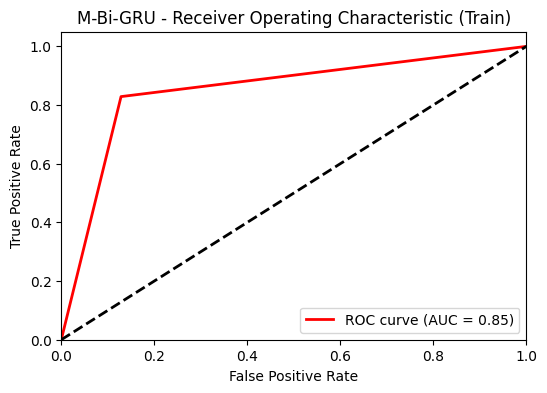

M-Bi-GRU AUC: 0.8502


In [96]:
if algorithm_class == "deep-learning":
  # Compute the ROC curve
  fpr, tpr, thresholds = roc_curve(train_labels, train_predictions)

  # Compute the AUC
  auc_score = auc(fpr, tpr)
  results_df.at["ROC-AUC-Train", deep_learning_model] = auc_score

  # Plot ROC curve
  plt.figure(figsize=(6, 4))
  plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
  plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'{deep_learning_model} - Receiver Operating Characteristic (Train)')
  plt.legend(loc="lower right")
  if save_results == True:
    plt.savefig(f"RESULTS/{dataset_name.upper()}/RNN/PLOTS/{embedding_method_name}_{deep_learning_model}_ROC_Train")
  plt.show()

  # Print AUC score
  print(f"{deep_learning_model} AUC: {auc_score:.4f}")

#### Validation

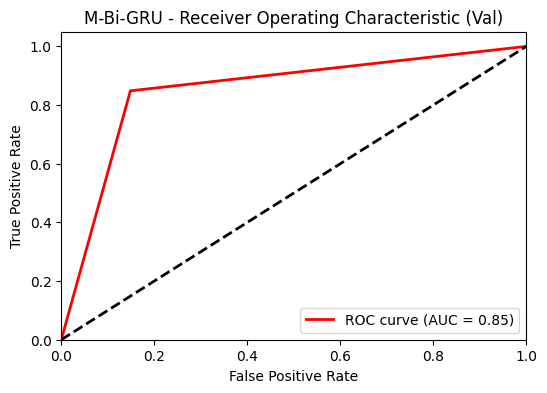

M-Bi-GRU AUC: 0.8499


In [97]:
if algorithm_class == "deep-learning":
  # Compute the ROC curve
  fpr, tpr, thresholds = roc_curve(val_labels, val_predictions)

  # Compute the AUC
  auc_score = auc(fpr, tpr)
  results_df.at["ROC-AUC-Val", deep_learning_model] = auc_score

  # Plot ROC curve
  plt.figure(figsize=(6, 4))
  plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
  plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'{deep_learning_model} - Receiver Operating Characteristic (Val)')
  plt.legend(loc="lower right")
  if save_results == True:
    plt.savefig(f"RESULTS/{dataset_name.upper()}/RNN/PLOTS/{embedding_method_name}_{deep_learning_model}_ROC_Val")
  plt.show()

  # Print AUC score
  print(f"{deep_learning_model} AUC: {auc_score:.4f}")

#### Train

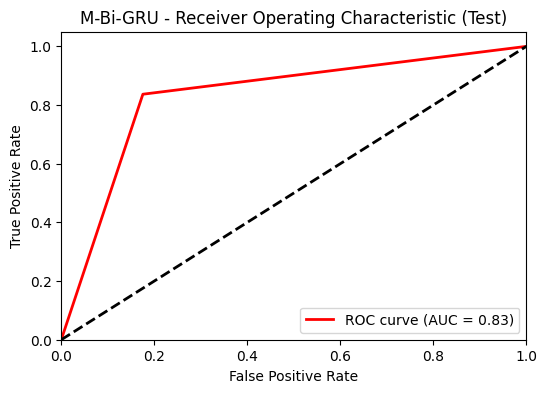

M-Bi-GRU AUC: 0.8307


In [98]:
if algorithm_class == "deep-learning":
  # Compute the ROC curve
  fpr, tpr, thresholds = roc_curve(test_labels, test_predictions)

  # Compute the AUC
  auc_score = auc(fpr, tpr)
  results_df.at["ROC-AUC-Test", deep_learning_model] = auc_score

  # Plot ROC curve
  plt.figure(figsize=(6, 4))
  plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
  plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'{deep_learning_model} - Receiver Operating Characteristic (Test)')
  plt.legend(loc="lower right")
  if save_results == True:
    plt.savefig(f"RESULTS/{dataset_name.upper()}/RNN/PLOTS/{embedding_method_name}_{deep_learning_model}_ROC_Test")
  plt.show()

  # Print AUC score
  print(f"{deep_learning_model} AUC: {auc_score:.4f}")

### Confusion Matrix

#### Train

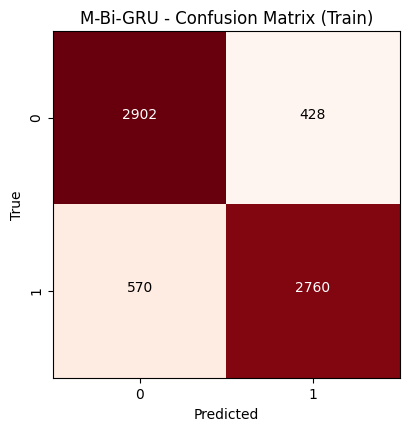

In [99]:
if algorithm_class == "deep-learning":

  # Create a confusion matrix
  cm = confusion_matrix(train_labels, train_predictions)

  # Use matplotlib to create a heatmap
  plt.figure(figsize=(4, 4))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)

  # Set up the labels
  tick_marks = np.arange(2)  # there are 2 classes: 0 and 1
  plt.xticks(tick_marks, [0, 1])
  plt.yticks(tick_marks, [0, 1], rotation=90)

  # Add the values in the cells
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], 'd'),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.title(f'{deep_learning_model} - Confusion Matrix (Train)')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if save_results == True:
    plt.savefig(f"RESULTS/{dataset_name.upper()}/RNN/PLOTS/{embedding_method_name}_{deep_learning_model}_CM_Train", bbox_inches='tight')
  plt.show()

#### Validation

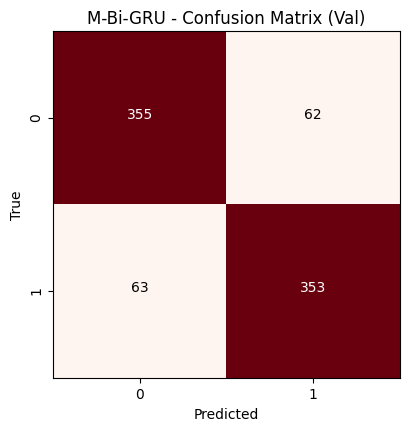

In [100]:
if algorithm_class == "deep-learning":

  # Create a confusion matrix
  cm = confusion_matrix(val_labels, val_predictions)

  # Use matplotlib to create a heatmap
  plt.figure(figsize=(4, 4))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)

  # Set up the labels
  tick_marks = np.arange(2)  # there are 2 classes: 0 and 1
  plt.xticks(tick_marks, [0, 1])
  plt.yticks(tick_marks, [0, 1], rotation=90)

  # Add the values in the cells
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], 'd'),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.title(f'{deep_learning_model} - Confusion Matrix (Val)')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if save_results == True:
    plt.savefig(f"RESULTS/{dataset_name.upper()}/RNN/PLOTS/{embedding_method_name}_{deep_learning_model}_CM_Val", bbox_inches='tight')
  plt.show()

#### Test

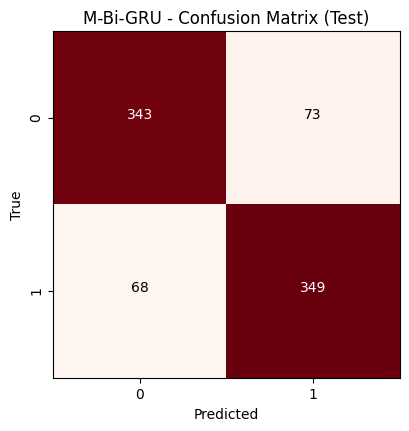

In [101]:
if algorithm_class == "deep-learning":

  # Create a confusion matrix
  cm = confusion_matrix(test_labels, test_predictions)

  # Use matplotlib to create a heatmap
  plt.figure(figsize=(4, 4))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)

  # Set up the labels
  tick_marks = np.arange(2)  # there are 2 classes: 0 and 1
  plt.xticks(tick_marks, [0, 1])
  plt.yticks(tick_marks, [0, 1], rotation=90)

  # Add the values in the cells
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], 'd'),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.title(f'{deep_learning_model} - Confusion Matrix (Test)')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if save_results == True:
    plt.savefig(f"RESULTS/{dataset_name.upper()}/RNN/PLOTS/{embedding_method_name}_{deep_learning_model}_CM_Test", bbox_inches='tight')
  plt.show()

In [102]:
if save_results == True and algorithm_class == "deep-learning":
  results_df.to_csv(f"RESULTS/{dataset_name.upper()}/RNN/METRICS/{embedding_method_name}_results.csv")

# Transformers

## Fine-Tune Transformer Model

In [103]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

In [104]:
if algorithm_class == "transformers":
  # Load model
  model = AutoModelForSequenceClassification.from_pretrained(transformer_model, num_labels=2)

  # Training arguments
  training_args = TrainingArguments(
      output_dir=f"{transformer_model}_results",
      num_train_epochs=1,
      per_device_train_batch_size=8,
      per_device_eval_batch_size=8,
      warmup_steps=500,
      weight_decay=0.01,
      logging_dir=f"{transformer_model}_logs",
      logging_steps=10,
      evaluation_strategy="epoch",
      save_strategy="epoch",
      seed=42,
  )

  # Create Trainer
  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=encoded_train_dataset,
      eval_dataset=encoded_val_dataset,
      tokenizer=tokenizer,
      compute_metrics=compute_metrics,
  )

  # Fine-tune the model
  start = time.time()
  trainer.train()
  end = time.time()
  results_df.at["Execution-Train", f"{transformer_model}"] = end - start

## Evaluation

In [105]:
model_results_path = f"/content/drive/MyDrive/Master/Dizertatie/RESULTS/{transformer_model.upper()}"
os.makedirs(model_results_path, exist_ok=True)

### Predictions

In [106]:
def get_predictions(trainer, dataset):
    # Get raw model predictions
    predictions_output = trainer.predict(dataset)
    predictions = predictions_output.predictions

    # Apply softmax and argmax to get predicted classes
    predicted_classes = np.argmax(softmax(predictions, axis=1), axis=1)
    true_labels = predictions_output.label_ids

    return predicted_classes, true_labels

In [108]:
if algorithm_class == "transformers":
  train_preds, train_labels = get_predictions(trainer, encoded_train_dataset)
  val_preds, val_labels = get_predictions(trainer, encoded_val_dataset)
  test_preds, test_labels = get_predictions(trainer, encoded_test_dataset)

### Accuracy

#### Train

In [109]:
if algorithm_class == "transformers":
  start = time.time()
  train_accuracy = accuracy_score(train_labels, train_preds)
  end = time.time()
  results_df.at["Execution-Train", transformer_model] = end - start
  results_df.at["Accuracy-Train", transformer_model] = train_accuracy
  print(f"{transformer_model} Train accuracy: {train_accuracy:.4f}")

#### Validation

In [110]:
if algorithm_class == "transformers":
  start = time.time()
  val_accuracy = accuracy_score(val_labels, val_preds)
  end = time.time()
  results_df.at["Execution-Val", transformer_model] = end - start
  results_df.at["Accuracy-Val", transformer_model] = val_accuracy
  print(f"{transformer_model} Val accuracy: {val_accuracy:.4f}")

#### Test

In [111]:
if algorithm_class == "transformers":
  start = time.time()
  test_accuracy = accuracy_score(test_labels, test_preds)
  end = time.time()
  results_df.at["Execution-Test", transformer_model] = end - start
  results_df.at["Accuracy-Test", transformer_model] = test_accuracy
  print(f"{transformer_model} Test accuracy: {test_accuracy:.4f}")

#### Precision, Recall and F1 Score

#### Train

In [112]:
if algorithm_class == "transformers":
  precision_train = precision_score(train_labels, train_preds)
  recall_train = recall_score(train_labels, train_preds)
  f1_train = f1_score(train_labels, train_preds)

  results_df.at["Precision-Train", transformer_model] = precision_train
  results_df.at["Recall-Train", transformer_model] = recall_train
  results_df.at["F1-Train", transformer_model] = f1_train

  print(f"{transformer_model} (Train Set) - Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1 Score: {f1_train:.4f}")

#### Validation

In [113]:
if algorithm_class == "transformers":
  precision_val = precision_score(val_labels, val_preds)
  recall_val = recall_score(val_labels, val_preds)
  f1_val = f1_score(val_labels, val_preds)

  results_df.at["Precision-Val", transformer_model] = precision_val
  results_df.at["Recall-Val", transformer_model] = recall_val
  results_df.at["F1-Val", transformer_model] = f1_val

  print(f"{transformer_model} (Val Set) - Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1 Score: {f1_val:.4f}")

#### Test

In [114]:
if algorithm_class == "transformers":
  precision_test = precision_score(test_labels, test_preds)
  recall_test = recall_score(test_labels, test_preds)
  f1_test = f1_score(test_labels, test_preds)

  results_df.at["Precision-Test", transformer_model] = precision_test
  results_df.at["Recall-Test", transformer_model] = recall_test
  results_df.at["F1-Test", transformer_model] = f1_test

  print(f"{transformer_model} (Test Set) - Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1 Score: {f1_test:.4f}")

### MAR and FAR

In [115]:
def compute_mar(TN, FP, FN, TP):
    miss_alarm_rate = FN / (TP + FN)
    return miss_alarm_rate

In [116]:
def compute_far(TN, FP, FN, TP):
    false_alarm_rate = FP / (FP + TN)
    return false_alarm_rate

#### Train

In [117]:
if algorithm_class == "transformers":
  tn, fp, fn, tp = confusion_matrix(train_labels, train_preds).ravel()

  mar_train = compute_mar(tn, fp, fn, tp)
  far_train = compute_far(tn, fp, fn, tp)

  results_df.at["MAR-Train", transformer_model] = mar_train
  results_df.at["FAR-Train", transformer_model] = far_train

  print(f"{transformer_model} (Train Set) - MAR: {mar_train:.4f}, FAR: {far_train:.4f}")

#### Validation

In [118]:
if algorithm_class == "transformers":
  tn, fp, fn, tp = confusion_matrix(val_labels, val_preds).ravel()

  mar_val = compute_mar(tn, fp, fn, tp)
  far_val = compute_far(tn, fp, fn, tp)

  results_df.at["MAR-Val", transformer_model] = mar_val
  results_df.at["FAR-Val", transformer_model] = far_val

  print(f"{transformer_model} (Val Set) - MAR: {mar_val:.4f}, FAR: {far_val:.4f}")

#### Test

In [119]:
if algorithm_class == "transformers":
  tn, fp, fn, tp = confusion_matrix(test_labels, test_preds).ravel()

  mar_test = compute_mar(tn, fp, fn, tp)
  far_test = compute_far(tn, fp, fn, tp)

  results_df.at["MAR-Test", transformer_model] = mar_test
  results_df.at["FAR-Test", transformer_model] = far_test

  print(f"{transformer_model} (Test Set) - MAR: {mar_test:.4f}, FAR: {far_test:.4f}")

### ROC and AUC

#### Train

In [120]:
if algorithm_class == "transformers":
  # Compute the ROC curve
  fpr, tpr, thresholds = roc_curve(train_labels, train_preds)

  # Compute the AUC
  auc_score = auc(fpr, tpr)
  results_df.at["ROC-AUC-Train", transformer_model] = auc_score

  # Plot ROC curve
  plt.figure(figsize=(6, 4))
  plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
  plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'{transformer_model} - Receiver Operating Characteristic (Train)')
  plt.legend(loc="lower right")
  if save_results:
    plt.savefig(f"{model_results_path}/ROC_Train")
  plt.show()

  # Print AUC score
  print(f"{transformer_model} AUC (Train Set): {auc_score:.4f}")

#### Validation

In [121]:
if algorithm_class == "transformers":
  # Compute the ROC curve
  fpr, tpr, thresholds = roc_curve(val_labels, val_preds)

  # Compute the AUC
  auc_score = auc(fpr, tpr)
  results_df.at["ROC-AUC-Val", transformer_model] = auc_score

  # Plot ROC curve
  plt.figure(figsize=(6, 4))
  plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
  plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'{transformer_model} - Receiver Operating Characteristic (Val)')
  plt.legend(loc="lower right")
  if save_results:
    plt.savefig(f"{model_results_path}/ROC_Val")
  plt.show()

  # Print AUC score
  print(f"{transformer_model} AUC (Val Set): {auc_score:.4f}")

#### Test

In [122]:
if algorithm_class == "transformers":
  # Compute the ROC curve
  fpr, tpr, thresholds = roc_curve(test_labels, test_preds)

  # Compute the AUC
  auc_score = auc(fpr, tpr)
  results_df.at["ROC-AUC-Test", transformer_model] = auc_score

  # Plot ROC curve
  plt.figure(figsize=(6, 4))
  plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
  plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'{transformer_model} - Receiver Operating Characteristic (Test))')
  plt.legend(loc="lower right")
  if save_results:
    plt.savefig(f"{model_results_path}/ROC_Test")
  plt.show()

  # Print AUC score
  print(f"{transformer_model} AUC (Test Set): {auc_score:.4f}")

### Confusion Matrix

#### Train

In [123]:
 if algorithm_class == "transformers":
  cm = confusion_matrix(train_labels, train_preds)
  # Use matplotlib to create a heatmap
  plt.figure(figsize=(4, 4))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
  # Set up the labels
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, [0, 1])
  plt.yticks(tick_marks, [0, 1], rotation=90)
  # Add the values in the cells
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], 'd'),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.title(f'{transformer_model} - Confusion Matrix (Train)')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if save_results:
    plt.savefig(f"{model_results_path}/CM_Train", bbox_inches='tight')
  plt.show()

#### Validation

In [124]:
if algorithm_class == "transformers":
  cm = confusion_matrix(val_labels, val_preds)
  # Use matplotlib to create a heatmap
  plt.figure(figsize=(4, 4))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
  # Set up the labels
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, [0, 1])
  plt.yticks(tick_marks, [0, 1], rotation=90)
  # Add the values in the cells
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], 'd'),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.title(f'{transformer_model} - Confusion Matrix (Val)')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if save_results:
        plt.savefig(f"{model_results_path}/CM_Val", bbox_inches='tight')
  plt.show()

#### Test

In [125]:
if algorithm_class == "transformers":
  cm = confusion_matrix(test_labels, test_preds)
  # Use matplotlib to create a heatmap
  plt.figure(figsize=(4, 4))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
  # Set up the labels
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, [0, 1])
  plt.yticks(tick_marks, [0, 1], rotation=90)
  # Add the values in the cells
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], 'd'),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.title(f'{transformer_model} - Confusion Matrix (Test)')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  if save_results:
        plt.savefig(f"{model_results_path}/CM_Test", bbox_inches='tight')
  plt.show()

In [126]:
results_df

,LSTM,GRU,Bi-LSTM,Bi-GRU,M-LSTM,M-GRU,M-Bi-LSTM,M-Bi-GRU
Accuracy-Train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.85015
Accuracy-Val,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.84994
Accuracy-Test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830732
Loss-Train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.339701
Loss-Val,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.352082
Loss-Test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.394199
Execution-Train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,212.354766
Execution-Val,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.447096
Execution-Test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.204821
Precision-Train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.865747
